In [1]:
!pip install sacrebleu


     |████████████████████████████████| 90 kB 636 kB/s 


Nama: Daniel Riyanto  
NIM : 13518075

## Reading Data

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Input, GRU, Embedding, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import unicodedata
import re
import time

In [3]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                 if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    return w

In [4]:
NUM_EXAMPLES = 12000

id_strings_array = np.array([], dtype='object')
with open('/kaggle/input/iwslt17/IWSLT17.train.en-id.id') as my_file:
    for line in my_file.readlines():
        if len(id_strings_array) < NUM_EXAMPLES:
            id_strings_array = np.append(id_strings_array, line)
        else:
            break
    id_strings_array = np.array([line.rstrip() for line in id_strings_array], dtype='object')

en_strings_array = np.array([], dtype='object')
with open('/kaggle/input/iwslt17/IWSLT17.train.en-id.en') as my_file:
    for line in my_file.readlines():
        if len(en_strings_array) < NUM_EXAMPLES:
            en_strings_array = np.append(en_strings_array, line)
        else:
            break
    en_strings_array = np.array([line.rstrip() for line in en_strings_array], dtype='object')

df = pd.DataFrame({'english': en_strings_array,'indonesia': id_strings_array})

df['indonesia'] = df.apply(lambda row: "<start> " + preprocess_sentence(row['indonesia']) + " <end>", axis=1)
df['english'] = df.apply(lambda row: preprocess_sentence(row['english']), axis=1)

In [5]:
df.head()

,english,indonesia
0,"thank you so much , chris . and it s truly a g...","<start> terima kasih banyak , chris . dan adal..."
1,"i have been blown away by this conference , an...",<start> saya terharu sekali oleh konferensi in...
2,"and i say that sincerely , partly because mock...",<start> dan saya katakan itu dari dalam hati s...
3,i ll tell you one quick story to illustrate wh...,<start> tepuk tangan biar saya ceritakan sebua...
4,it s a true story every bit of this is true .,<start> ini adalah cerita yang benar benar ter...


In [6]:
### Get English and Indonesia Vocabulary
all_eng_words=set()
for eng in df['english']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_ind_words=set()
for ind in df['indonesia']:
    for word in ind.split():
        if word not in all_ind_words:
            all_ind_words.add(word)

In [7]:
len(all_eng_words)

12989

In [8]:
len(all_ind_words)

12255

In [9]:
df['length_eng_sentence']=df['english'].apply(lambda x:len(x.split(" ")))
df['length_ind_sentence']=df['indonesia'].apply(lambda x:len(x.split(" ")))

In [10]:
df.head()

,english,indonesia,length_eng_sentence,length_ind_sentence
0,"thank you so much , chris . and it s truly a g...","<start> terima kasih banyak , chris . dan adal...",29,32
1,"i have been blown away by this conference , an...",<start> saya terharu sekali oleh konferensi in...,32,29
2,"and i say that sincerely , partly because mock...",<start> dan saya katakan itu dari dalam hati s...,46,46
3,i ll tell you one quick story to illustrate wh...,<start> tepuk tangan biar saya ceritakan sebua...,17,19
4,it s a true story every bit of this is true .,<start> ini adalah cerita yang benar benar ter...,12,15


In [11]:
print("maximum length of Indonesia Sentence ",max(df['length_ind_sentence']))
print("maximum length of English Sentence ",max(df['length_eng_sentence']))

maximum length of Indonesia Sentence  88
maximum length of English Sentence  85


In [12]:
max_length_src=max(df['length_eng_sentence'])
max_length_tar=max(df['length_ind_sentence'])

In [13]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_ind_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_ind_words)
num_encoder_tokens, num_decoder_tokens

(12989, 12255)

In [14]:
num_decoder_tokens += 1 #for zero padding

In [15]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [16]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

### Split the data into train and test

In [17]:
X, y = df['english'], df['indonesia']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
X_train.shape, X_test.shape

((9600,), (2400,))

Save the data for other model

In [18]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_test.to_pickle('y_test.pkl')

In [19]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

### Encoder-Decoder Architecture

In [20]:
latent_dim=300

In [21]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_gru = GRU(latent_dim, return_state=True)
encoder_outputs, state_h = encoder_gru(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h]

2021-11-16 14:39:44.578308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 14:39:44.681467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 14:39:44.682192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 14:39:44.683366: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [22]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder_gru(dec_emb,
                                 initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [23]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    3896700     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    3676800     input_2[0][0]                    
______________________________________________________________________________________________

In [25]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 20 # Change

In [26]:
H = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                        steps_per_epoch = train_samples//batch_size,
                        epochs=epochs,
                        validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                        validation_steps = val_samples//batch_size)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-11-16 14:39:49.507390: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-11-16 14:39:57.101070: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


75/75 [==============================] - 89s 1s/step - loss: 1.3618 - val_loss: 1.2869
Epoch 2/20
75/75 [==============================] - 78s 1s/step - loss: 1.2296 - val_loss: 1.2454
Epoch 3/20
75/75 [==============================] - 78s 1s/step - loss: 1.1758 - val_loss: 1.2087
Epoch 4/20
75/75 [==============================] - 78s 1s/step - loss: 1.1342 - val_loss: 1.1848
Epoch 5/20
75/75 [==============================] - 78s 1s/step - loss: 1.0999 - val_loss: 1.1714
Epoch 6/20
75/75 [==============================] - 78s 1s/step - loss: 1.0702 - val_loss: 1.1547
Epoch 7/20
75/75 [==============================] - 78s 1s/step - loss: 1.0424 - val_loss: 1.1500
Epoch 8/20
75/75 [==============================] - 78s 1s/step - loss: 1.0161 - val_loss: 1.1414
Epoch 9/20
75/75 [==============================] - 78s 1s/step - loss: 0.9923 - val_loss: 1.1368
Epoch 10/20
75/75 [==============================] - 78s 1s/step - loss: 0.9689 - val_loss: 1.1263
Epoch 11/20
75/75 [===========

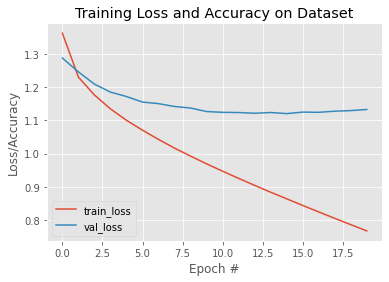

In [27]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot_encoder_decoder_gru.png")

In [28]:
model.save_weights('nmt_weights_gru.h5')

In [29]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2 = decoder_gru(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [30]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['<start>']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '<end>' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h]

    return decoded_sentence

In [31]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [32]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Indonesia Translation:', y_train[k:k+1].values[0][8:-6])
print('Predicted Indonesia Translation:', decoded_sentence[:-6])

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py:202 assert_input_compatibility
        ' input tensors. Inputs received: ' + str(inputs))

    ValueError: Layer model_2 expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 1, 300) dtype=float32>]


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Indonesia Translation:', y_train[k:k+1].values[0][8:-6])
print('Predicted Indonesia Translation:', decoded_sentence[:-6])

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Indonesia Translation:', y_train[k:k+1].values[0][8:-6])
print('Predicted Indonesia Translation:', decoded_sentence[:-6])

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Indonesia Translation:', y_train[k:k+1].values[0][8:-6])
print('Predicted Indonesia Translation:', decoded_sentence[:-6])

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Indonesia Translation:', y_train[k:k+1].values[0][8:-6])
print('Predicted Indonesia Translation:', decoded_sentence[:-6])

In [ ]:
from sacrebleu.metrics import BLEU

bleu = BLEU()

In [ ]:
refs = [[sentence[8:-6] for sentence in y_test[:5]]]

In [ ]:
hyps = []
test_gen = generate_batch(X_test[:5], y_test[:5], batch_size = 1)
for i in range(0, 5):
    (input_seq, actual_output), _ = next(test_gen)
    hyps.append(decode_sequence(input_seq)[1:-6])
    print(i, end='\r')

In [ ]:
result = bleu.corpus_score(hyps, refs)
print(result)